In [2]:
import pandas as pd

df = pd.read_csv("../data/features_15k.csv")


In [3]:
# Separate classes
df_real = df[df["label"] == 0].sample(5000, random_state=42)
df_edited = df[df["label"] == 1].sample(2500, random_state=42)
df_ai = df[df["label"] == 2].sample(2500, random_state=42)

# Combine
df_balanced = pd.concat([df_real, df_edited, df_ai], ignore_index=True)

# Create binary label: REAL=0, FAKE=1
df_balanced["binary_label"] = df_balanced["label"].apply(
    lambda x: 0 if x == 0 else 1
)

df_balanced["binary_label"].value_counts()


binary_label
0    5000
1    5000
Name: count, dtype: int64

In [4]:
from sklearn.model_selection import train_test_split

X = df_balanced.drop(columns=["image_id", "label", "binary_label"])
y = df_balanced["binary_label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Define model
binary_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

# Train
binary_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=300, n_jobs=-1, random_state=42)

In [6]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = binary_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["REAL", "FAKE"]))


Accuracy: 0.7125
              precision    recall  f1-score   support

        REAL       0.70      0.75      0.72      1000
        FAKE       0.73      0.67      0.70      1000

    accuracy                           0.71      2000
   macro avg       0.71      0.71      0.71      2000
weighted avg       0.71      0.71      0.71      2000



In [7]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["REAL", "FAKE"],
    yticklabels=["REAL", "FAKE"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Balanced Real vs Fake")
plt.show()


In [25]:
import joblib

joblib.dump(binary_model, "../backend/model_binary.pkl")
print("✅ Balanced binary model saved")


✅ Balanced binary model saved


## RL threshold calibration

In [8]:
import numpy as np

# Get probabilities on validation set
probs = binary_model.predict_proba(X_test)
conf = probs.max(axis=1)
preds = probs.argmax(axis=1)   # 0 = REAL, 1 = FAKE
true = y_test.values

def compute_reward(threshold):
    total_reward = 0

    for i in range(len(true)):
        confidence = conf[i]
        pred = preds[i]
        actual = true[i]

        # Decision rule
        if pred == 1 and confidence >= threshold:
            decision = 1   # FAKE
        else:
            decision = 0   # REAL

        # Reward logic
        if decision == actual:
            total_reward += 1
        else:
            if decision == 1 and actual == 0:
                total_reward -= 3   # False FAKE (high penalty)
            else:
                total_reward -= 1   # False REAL

    return total_reward


# Try multiple thresholds
thresholds = np.arange(0.50, 0.90, 0.02)
rewards = []

for t in thresholds:
    r = compute_reward(t)
    rewards.append(r)

best_threshold = thresholds[np.argmax(rewards)]

print("Optimal Threshold:", round(best_threshold, 2))
print("Max Reward:", max(rewards))


Optimal Threshold: 0.6
Max Reward: 598


In [9]:
import matplotlib.pyplot as plt

plt.plot(thresholds, rewards, marker="o")
plt.xlabel("Confidence Threshold")
plt.ylabel("Total Reward")
plt.title("RL-Inspired Threshold Optimization")
plt.grid(True)
plt.show()


# decision threshold calibration

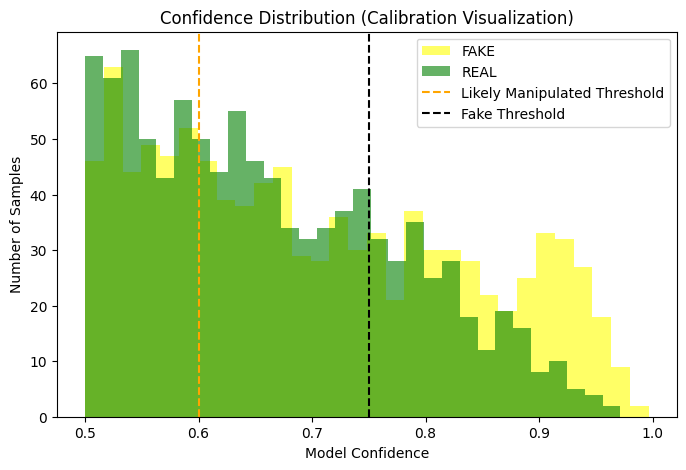

In [30]:
import matplotlib.pyplot as plt

# Get probabilities on validation/test set
probs = binary_model.predict_proba(X_test)
conf = probs.max(axis=1)

real_conf = conf[y_test == 0]
fake_conf = conf[y_test == 1]

plt.figure(figsize=(8,5))
plt.hist(fake_conf, bins=30, alpha=0.6, label="FAKE", color="yellow")
plt.hist(real_conf, bins=30, alpha=0.6, label="REAL", color="green")

plt.axvline(0.60, color="orange", linestyle="--", label="Likely Manipulated Threshold")
plt.axvline(0.75, color="black", linestyle="--", label="Fake Threshold")

plt.xlabel("Model Confidence")
plt.ylabel("Number of Samples")
plt.title("Confidence Distribution (Calibration Visualization)")
plt.legend()
plt.show()
